In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (f1_score, ConfusionMatrixDisplay)


In [29]:
df = pd.read_csv("/Users/EthanMcElhone/Downloads/data-1.csv") 

In [30]:
def evaluate_cv(estimator, X, y, scoring_list, model_name = "model"):
    
    #Define StratifiedKFold splitter. This makes sure than no split is more imbalanced than the original data
    cv_splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    #Calculate the CV score for each metric
    cv_results = cross_validate(
        estimator, 
        X, 
        y, 
        scoring = scoring_list, 
        cv = cv_splitter, 
        return_train_score=False
    )

    #Create a dataframe with all the performance metrics using cv
    row = {"model": model_name}
    for k, v in cv_results.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            row[f"{metric}"] = np.mean(v)
        
    return pd.DataFrame([row]).set_index("model")

In [31]:
def predict_evaluate(estimator, X_tr: pd.DataFrame, X_ts: pd.DataFrame, y_tr: pd.DataFrame, y_ts, model_name: str):

    #Fit the estimator on the training data
    classifier = estimator.fit(X_tr, y_tr)

    #Find the predictions and probabilities
    predictions = classifier.predict(X_ts)

    #Calculate the error metrics using predictions
    f1 = f1_score(y_ts, predictions, average="binary", pos_label=1)

    return pd.DataFrame({"model": [model_name], "F1": [f1]}), predictions

In [32]:
def multiple_predict_evaluate(models:list[tuple], X_tr: pd.DataFrame, X_ts: pd.DataFrame, y_tr, y_ts):

    #Create a list of dataframes to hold the performances of each model
    metrics_list = []

    #Create a list of dataframes to hold the predictions from each model
    predictions_list = []

      #Iterate through each model
    for model, estimator in models:
        
        #report the performance and predicitions of the model
        metric, preds = predict_evaluate(estimator, X_tr, X_ts, y_tr, y_ts, model)

        #Append the performance to the metrics list
        metrics_list.append(metric)

        #Create dataframe to hold the predictions
        df_model = pd.DataFrame({f"{model}": preds})

        #Append the dataframe to the  predictions_list
        predictions_list.append(df_model)

    #Return the concatenated dataframes
    return pd.concat(metrics_list, ignore_index = True), pd.concat(predictions_list, axis = 1)

In [33]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize, model_name):

    #Create figure
    fig = plt.figure(figsize=(12, 12), dpi=100)  # FORCE a large, readable figure
    ax = fig.add_subplot(111)

    #Create Confusion Matrix display
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=class_names,
        normalize=normalize,
        cmap="Blues",
        colorbar=True,
        ax=ax
    )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.title(f"Confusion Matrix - {model_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

In [34]:
glacier_class = "snow / ice"

data_bin = df.copy()
data_bin["glacier"] = (data_bin["land_type"] == glacier_class).astype(int)

features = data_bin.drop(columns = ["land_type", "rgb_hex", "overlay_hex", "glacier"])
target = data_bin["glacier"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = target)

In [36]:
logistic_pca10 = Pipeline([
    ("scaler", StandardScaler()),
     ("pca", PCA(n_components=10)),
     ("logistic_classifier", LogisticRegression(
         solver = "lbfgs",
         max_iter=2000))])

rf_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        criterion='gini',
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        max_features='sqrt'))])

svm_raw = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=20,
        gamma="scale",
        probability=True))])

In [37]:
scoring_list = { "F1":"f1"}

In [40]:
rf_cv = evaluate_cv(rf_raw, X_train, y_train, scoring_list=scoring_list, model_name="RF Raw")

In [41]:
rf_cv

,F1
model,
RF Raw,0.988945


In [42]:
svm_cv = evaluate_cv(svm_raw, X_train, y_train, scoring_list=scoring_list, model_name="SVM RAW")

In [43]:
svm_cv

,F1
model,
SVM RAW,0.998156


In [48]:
logit_cv = evaluate_cv(logistic_pca10, X_train, y_train, scoring_list=scoring_list, model_name="Logistic_PCA10") 

In [49]:
logit_cv

,F1
model,
Logistic_PCA10,0.997075


In [50]:
models_list = [("Logistic_PCA10", logistic_pca10),
          ("RF_Raw", rf_raw),
          ("SVM_Raw", svm_raw)]

df_performances, df_predictions = multiple_predict_evaluate(models_list, X_train, X_test, y_train, y_test)

In [51]:
df_performances = df_performances.set_index("model")
df_performances

,F1
model,
Logistic_PCA10,0.997395
RF_Raw,0.991093
SVM_Raw,0.996745


In [55]:
df_predictions

,Logistic_PCA10,RF_Raw,SVM_Raw
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
43116,0,0,0
43117,0,0,0
43118,0,0,0
43119,0,0,0


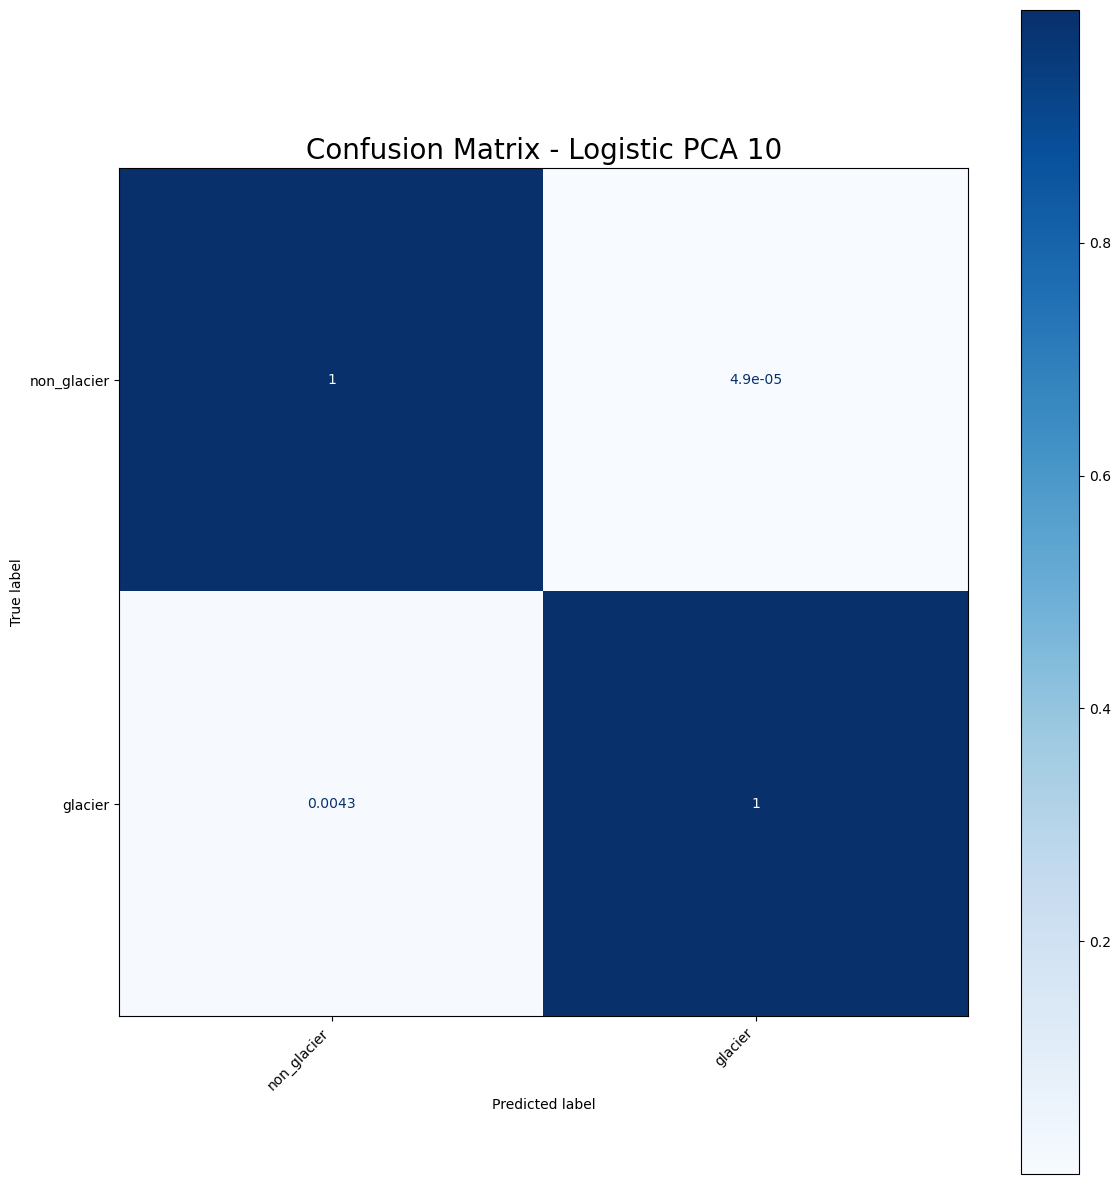

In [56]:
plot_confusion_matrix(y_true=y_test, y_pred=df_predictions["Logistic_PCA10"], class_names=["non_glacier", "glacier"], normalize="true", model_name="Logistic PCA 10")

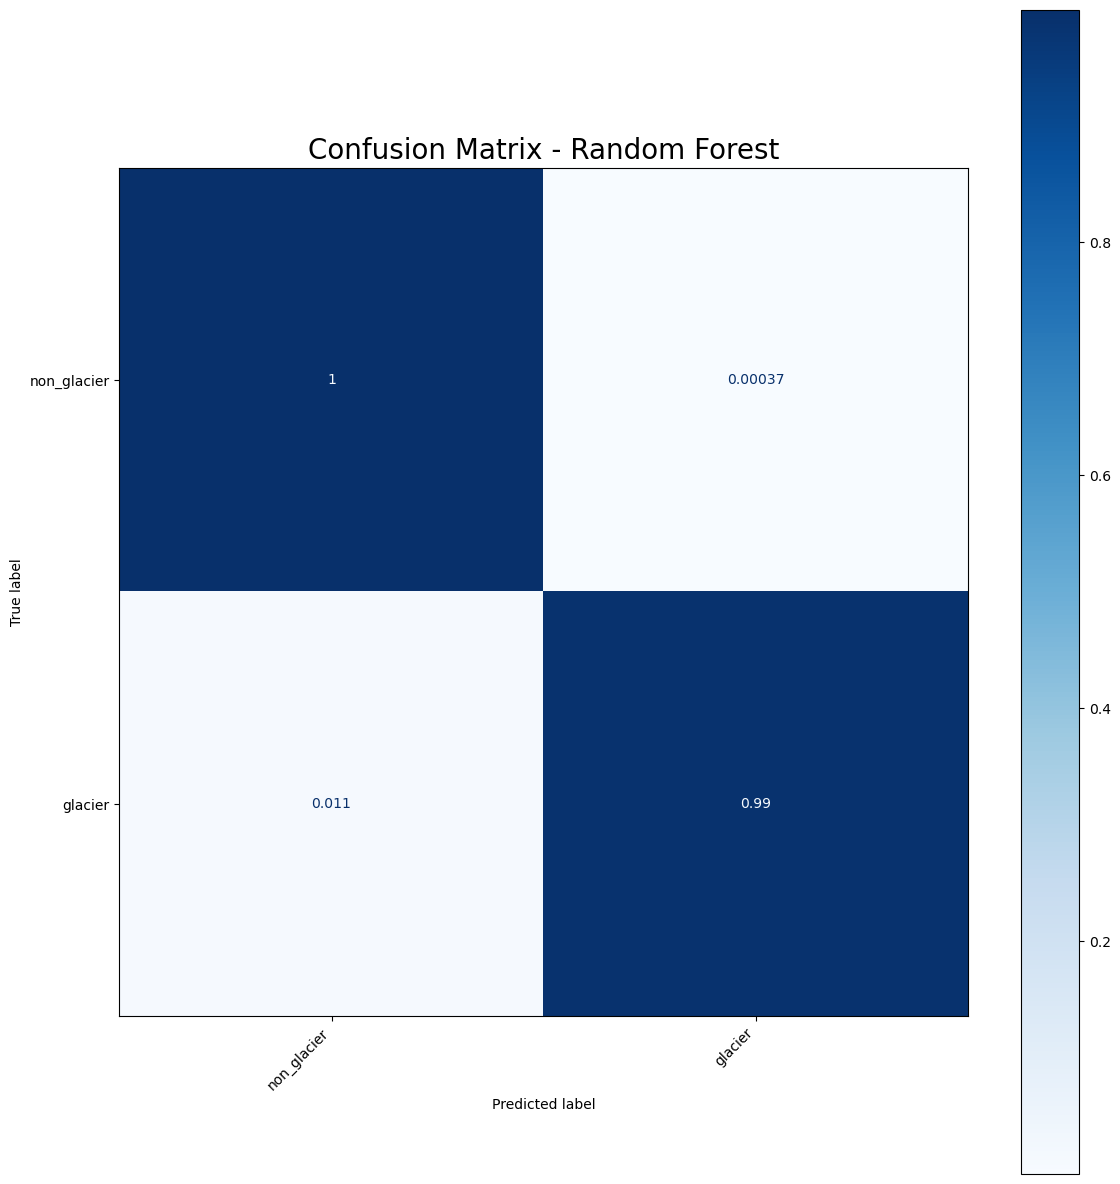

In [57]:
plot_confusion_matrix(y_true=y_test, y_pred=df_predictions["RF_Raw"], class_names=["non_glacier", "glacier"], normalize="true", model_name="Random Forest")

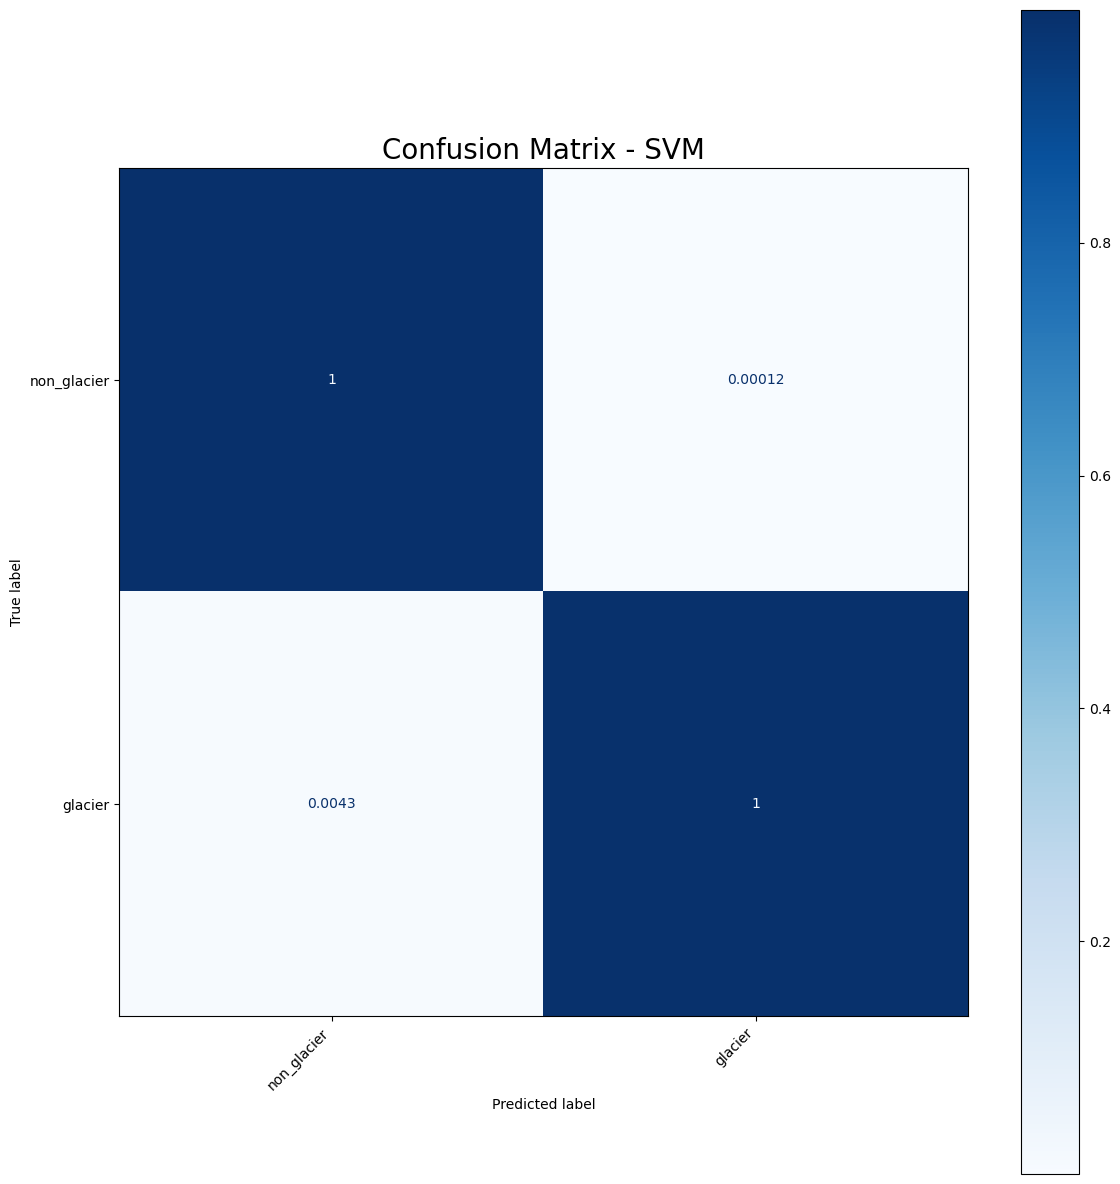

In [58]:
plot_confusion_matrix(y_true=y_test, y_pred=df_predictions["SVM_Raw"], class_names=["non_glacier", "glacier"], normalize="true", model_name="SVM")